In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [12]:
datasets = []
# guild compare -l sin -N -S "last 24 hours" --csv results/sin.csv
datasets.append('sin')
# guild compare -l cauchy -N -S "today" --csv results/cauchy.csv
datasets.append('cauchy')
# guild compare -l "physionet" -C --csv results/physionet.csv
datasets.append('physionet')


In [83]:
np_name_map = {
    'attentive_neural_process': 'Attentive\nNP', 
    'attentive_conditional_neural_process': 'Attentive\nConditional NP', 
    'neural_process': 'NP', 
    'conditional_neural_process': 'Conditional\nNP',
    "conv_conditional_neural_process": "Convolutional\nConditional\nNP"}
np_name_map = {
    'attentive_neural_process': 'ANP', 
    'attentive_conditional_neural_process': 'ACNP', 
    'neural_process': 'NP', 
    'conditional_neural_process': 'CNP',
    "conv_conditional_neural_process": "Convolutional\nConditional\nNP"}
def format_names(label, meta_learner, mean, kernel):
    if 'np' in label:
        return np_name_map[meta_learner]
    elif 'gp' in label:
        return f"{mean[0].upper()}{mean[1:3]}-$m$,\n{kernel}-$k$"


metrics = ['Eval/neg_log_likelihood', 'Eval/rmse', 'Eval/calibr_error']
metric_mapping = {'Eval/neg_log_likelihood': 'Negative log likelihood\n(NLL)', 
                  'Eval/rmse': 'Root-mean-square error\n(RMSE)', 
                  'Eval/calibr_error': 'Calibration error (CE)'}

sns.set_palette(sns.color_palette("husl", 8))

# Map colours to common order
colours = sns.color_palette("husl", 8)
# Do this inside the metrics loop if you want all metrics to go down.
# decreasing_order = df.groupby(by=["model_name"])['Eval/neg_log_likelihood'].mean().sort_values(ascending = False).index
fixed_order = ['NP', 'CNP', 
               'ANP', 'ACNP',
               'Con-$m$,\nSE-$k$', 'NN-$m$,\nSE-$k$',
               'Con-$m$,\nNN-$k$', 'NN-$m$,\nNN-$k$']
fixed_palette = sns.color_palette("husl", 8)


sin
cauchy
physionet


<ipython-input-101-fa870ce6a484>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_no_conv['model_name'] = pd.Categorical(df_full_no_conv['model_name'],
<ipython-input-101-fa870ce6a484>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_no_conv.sort_values("model_name", inplace=True)


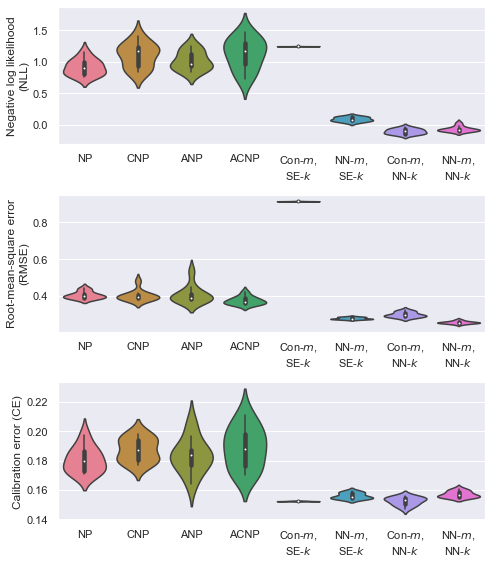

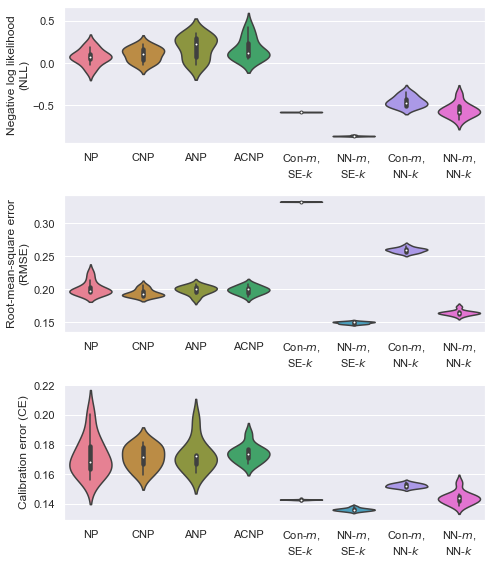

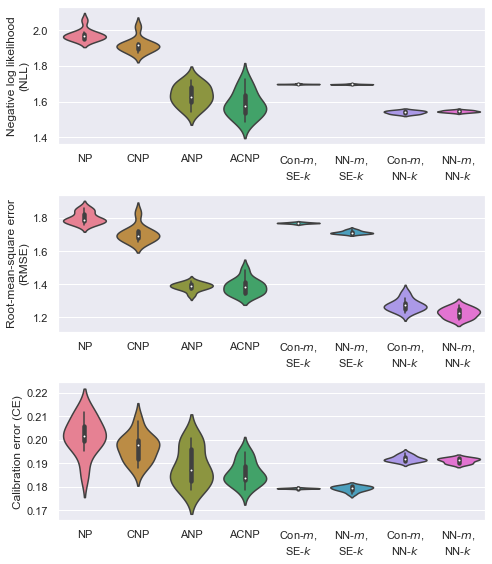

In [101]:
for dataset in datasets:
    df_full = pd.read_csv(f"results/{dataset}.csv")
    df_full['Eval/neg_log_likelihood'] = -df_full['Eval/log_likelihood']


    df_full["model_name"] = df_full.apply(lambda x : format_names(x["label"], x["meta_learner"], x["mean_module"], x["covar_module"]), axis=1)
    df_full_no_conv = df_full[df_full.meta_learner != 'conv_conditional_neural_process']
    print(f"{dataset}")
    df = df_full_no_conv
    plt.figure(figsize=(7,8))
    for i, metric in enumerate(metrics):
        # Find the order
        plt.subplot(3, 1, i+1)
    #     sns.pointplot(x = 'model_name', y=metric, data=df, estimator=np.mean, order=decreasing_order)
        g = sns.violinplot('model_name', metric, 
                           #hue='random_seed',
                           data=df, dodge=True, join=False,
                           order=fixed_order, scale='width', palette=fixed_palette)
        plt.xlabel('')
        plt.ylabel(metric_mapping[metric])
#     plt.suptitle(dataset)
    plt.tight_layout()
    # plt.xticks(rotation=30)
    plt.savefig(f'images/{dataset}_results.pgf')
    plt.savefig(f'images/{dataset}_results.png')
    df_full_no_conv['model_name'] = pd.Categorical(df_full_no_conv['model_name'],
                                                  fixed_order)
    df_full_no_conv.sort_values("model_name", inplace=True)
    results_table = df_full_no_conv.groupby(['model_name'], as_index=False).agg({
        'Eval/neg_log_likelihood': ['mean', 'std'],
        'Eval/rmse': ['mean', 'std'],
        'Eval/calibr_error': ['mean', 'std'],
    })
    results_table['Eval/neg_log_likelihood']['mean']
    new_results_table = pd.DataFrame(results_table['model_name'])
    metrics_mapping = {
        'Eval/neg_log_likelihood': "NLL",
        'Eval/rmse': "RMSE",
        'Eval/calibr_error': "CE",
    }
    for metric in metrics:
        short_metric = metrics_mapping[metric]
        # Sample mean and standard deviation
        new_results_table[short_metric] = results_table[metric][['mean', 'std']] \
            .astype(str) \
            .apply(lambda x: x.str[:5]) \
            .agg(' \pm '.join, axis=1)
    new_results_table = new_results_table.applymap(lambda x: x.replace('\n', ' '))
    new_results_table = new_results_table.applymap(lambda x: x.replace('+', ', '))
    new_results_table = new_results_table.set_index("model_name").transpose()


    new_results_table.to_latex(f'images/{dataset}_results.tex',
            escape=False,
            index_names=False,
            column_format="l*{8}{p{1.07cm}}",
            label=f"tab:{dataset}_results"
    #     columns=['', '', '', '']
    )


For the Cauchy dataset, the log-likelihoods of all the meta-GPR methods are superior to the NP models. Within GPR, NN-mean+SE-kernel is the best. This is because it has both good accuracy (lowest RMSE) due to the flexible mean function, and good calibration (lowest calibration error) from the SE kernel.

The "vanilla" meta-GP with const-mean+SE-kernel has rather high RMSE. because its SE kernel lacks flexibility and causes an overly smooth fit that misses target points, e.g. figure 9d2fe493 plot_2 iter 5000 (this is sin...) and the constant mean results in conservative mean-reverting behaviour that fails to extrapolate well outside of the context domain e.g. b7467fab plot_2 (cauchy, also shown in "overfitting" section).

In [ ]:
for dataset in datasets:


In [85]:
# df_full_no_conv['model_name'].map(lambda x: x.replace('A', ' '))
# df_multi_index = df_full_no_conv.set_index('model_name', 'run', 'Eval/neg_log_likelihood', inplace=False)
# df_multi_index[metrics].head()
df_full_no_conv['model_name'] = pd.Categorical(df_full_no_conv['model_name'],
                                               fixed_order)
df_full_no_conv.sort_values("model_name", inplace=True)
results_table = df_full_no_conv.groupby(['model_name'], as_index=False).agg({
    'Eval/neg_log_likelihood': ['mean', 'std'],
    'Eval/rmse': ['mean', 'std'],
    'Eval/calibr_error': ['mean', 'std'],
})
results_table['Eval/neg_log_likelihood']['mean']
# TO LATEX


<ipython-input-85-6d7c2892bc8a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_no_conv['model_name'] = pd.Categorical(df_full_no_conv['model_name'],
<ipython-input-85-6d7c2892bc8a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_no_conv.sort_values("model_name", inplace=True)


0    1.974036
1    1.917595
2    1.636297
3    1.587310
4    1.698523
5    1.697678
6    1.540897
7    1.545916
Name: mean, dtype: float64

In [91]:
new_results_table = pd.DataFrame(results_table['model_name'])
metrics_mapping = {
    'Eval/neg_log_likelihood': "NLL",
    'Eval/rmse': "RMSE",
    'Eval/calibr_error': "CE",
}
for metric in metrics:
    short_metric = metrics_mapping[metric]
    # Sample mean and standard deviation
    new_results_table[short_metric] = results_table[metric][['mean', 'std']] \
        .astype(str) \
        .apply(lambda x: x.str[:5]) \
        .agg(' \pm '.join, axis=1)
new_results_table = new_results_table.applymap(lambda x: x.replace('\n', ' '))
new_results_table = new_results_table.applymap(lambda x: x.replace('+', ', '))
new_results_table = new_results_table.set_index("model_name").transpose()
new_results_table

In [92]:
new_results_table

,model_name,NLL,RMSE,CE
0,NP,1.974 \pm 0.032,1.801 \pm 0.034,0.201 \pm 0.007
1,CNP,1.917 \pm 0.040,1.705 \pm 0.050,0.196 \pm 0.005
2,ANP,1.636 \pm 0.058,1.385 \pm 0.023,0.188 \pm 0.007
3,ACNP,1.587 \pm 0.072,1.386 \pm 0.047,0.185 \pm 0.005
4,"Con-$m$, SE-$k$",1.698 \pm 0.001,1.770 \pm 0.003,0.179 \pm 0.000
5,"NN-$m$, SE-$k$",1.697 \pm 0.001,1.713 \pm 0.009,0.179 \pm 0.001
6,"Con-$m$, NN-$k$",1.540 \pm 0.008,1.274 \pm 0.036,0.191 \pm 0.001
7,"NN-$m$, NN-$k$",1.545 \pm 0.005,1.227 \pm 0.030,0.191 \pm 0.001


In [95]:
print(new_results_table.to_latex(
    escape=False,
    index_names=False,
    column_format="l*{8}{p{1.07cm}}",
    label=f"tab:{dataset}_results"
#     columns=['', '', '', '']
))


\begin{tabular}{l*{8}{p{1.07cm}}}
\toprule
{} &               NP &              CNP &              ANP &             ACNP &  Con-$m$, SE-$k$ &   NN-$m$, SE-$k$ &  Con-$m$, NN-$k$ &   NN-$m$, NN-$k$ \\
\midrule
NLL  &  1.974 \pm 0.032 &  1.917 \pm 0.040 &  1.636 \pm 0.058 &  1.587 \pm 0.072 &  1.698 \pm 0.001 &  1.697 \pm 0.001 &  1.540 \pm 0.008 &  1.545 \pm 0.005 \\
RMSE &  1.801 \pm 0.034 &  1.705 \pm 0.050 &  1.385 \pm 0.023 &  1.386 \pm 0.047 &  1.770 \pm 0.003 &  1.713 \pm 0.009 &  1.274 \pm 0.036 &  1.227 \pm 0.030 \\
CE   &  0.201 \pm 0.007 &  0.196 \pm 0.005 &  0.188 \pm 0.007 &  0.185 \pm 0.005 &  0.179 \pm 0.000 &  0.179 \pm 0.001 &  0.191 \pm 0.001 &  0.191 \pm 0.001 \\
\bottomrule
\end{tabular}



Use in LaTeX document with
```
\usepackage{booktabs}
...
\input{mytable}
```

In [ ]:
with open(f'{dataset}_results.tex','w') as tf:
    tf.write(df_new.to_latex())